## 🤗트랜스포머를 사용해 나만의 이미지 분류기 만들기 (ViT)
---
* 이 글은 [Fine-Tune ViT for Image Classification with 🤗 Transformers](https://huggingface.co/blog/fine-tune-vit) 글을 번역 및 재구성했습니다.
* 이 코드는 Google Colab에서 동작하도록 만들었으며, 다른 개발환경에서는 코드를 일부 수정해야 할 수 있습니다.  
</p></br></br>


최근 자연어 처리(NLP) 모델이 딥러닝 분야에서 호황을 보여주고 있습니다. 그리고 이제는 다른 다양한 분야에서도 놀라운 성능의 이미지 처리 모델이 선보여지고 있는데요, 대표적으로 Google Brain에서 21년 6월에 선보인 [ViT(Vision Transformer)](https://arxiv.org/abs/2010.11929)가 있습니다.  
</p></br></br>


이 모델은 NLP 모델과 같이 이미지를 토큰화한 뒤 학습하는 방식을 보여주고 있습니다. 이 개념을 세줄 요약으로 설명해 보자면,  
</p></br></br>


1. 이미지 분할
1. linear projection 기법을 이용한 입력
1. 이 데이터를 토큰화한 뒤 모델로 전달하는 방법입니다.
</p></br></br>


![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)
</p></br></br>


이 작업을 도식화하면 위의 이미지와 같이 표현할 수 있습니다. 이미지 모델을 NLP처럼 처리한다는 점이 꽤 인상적입니다.
</p></br></br>


### ViT 미세 조정
---
그래서, 이번에는 파이썬(Python)에서 사용할 수 있는 트랜스포머(Transformers) 패키지를 이용해 간편한 ViT 미세 조정(fine-tuning)을 시도해 보겠습니다. 이 코드는 Google Colab에서 실행해 보시는걸 권장드립니다.
</p></br></br>



In [1]:
# %%capture 매직코드를 사용하면, 터미널 출력을 모두 저장할 수 있도록 합니다
%%capture

# datasets 패키지와 transformers가 설치되지 않았을 경우 설치해 주세요
! pip install datasets transformers

</p></br></br>


## 데이터 불러오기
---
이번에는 건강하게 자란 콩잎 사진과 병이 든 콩잎 사진을 분류할 수 있도록 해 보겠습니다. 데이터는 datasets 패키지의 beans를 불러오도록 하겠습니다. 이 데이터는 1034개의 train set, 133개의 validation set, 128개의 test set이 준비되어 있습니다. 🍃  
</p></br></br>



In [2]:
from datasets import load_dataset

ds = load_dataset('beans')
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

</p></br></br>


그리고, 콩잎 사진이 구체적으로 어떻게 찍혀 있는지 미리 살펴볼 수 있도록 코드를 실행해 보겠습니다. 이 데이터는 `image` 와 `image_file_path` , `labels` 라는 속성이 있습니다. 각각 아래와 같은 데이터가 있으니 참고해 주세요.  
</p></br></br>


1. `image`: PIL 이미지
1. `image_file_path`: 이미지 파일 경로 (문자열)
1. `labels`: [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) 라벨을 정수로 표기한 값
</p></br></br>



In [3]:
# train set의 400번째 이미지를 확인해 보겠습니다
ex = ds['train'][400]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.148.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 1}

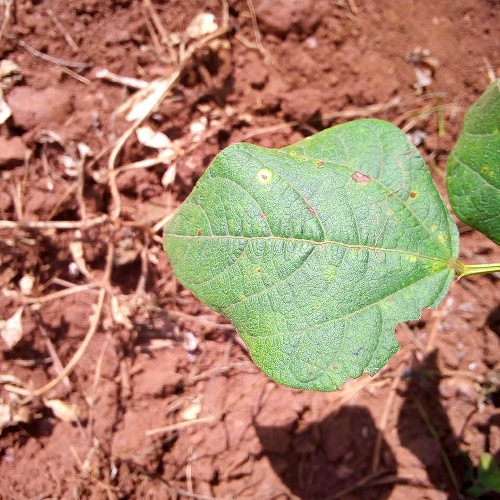

In [4]:
# 이미지 시각화하기
image = ex['image']
image

</p></br></br>


이렇게 콩잎이 찍힌 데이터를 확인할 수 있습니다. 이제는 이 콩잎이 어떤 종류인지(건강한지, 병에 걸렸는지) 알 수 있도록 라벨을 조회할 수 있어야 합니다. 이 콩잎 데이터에는 `labels` 라는 features가 있으므로, 이를 조회해 보도록 하겠습니다.</p></br></br>



In [5]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

</p></br></br>


각 라벨은 `angular_leaf_spot` , `bean_rust` , `healthy` 의 3종류로 구분되어 있는 것을 확인할 수 있습니다. 이제는 특정한 콩잎 사진이 어떤 상태인지 조회할 수 있도록 [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) 함수를 이용해 조회해 보도록 하겠습니다.
</p></br></br>



In [6]:
labels.int2str(ex['labels'])

'bean_rust'

</p></br></br>


데이터를 살펴본 결과, 이 콩잎 사진의 식물은 콩과 식물에서 발생하는 심각한 질병인 콩 녹병(Bean Rust)에 감염되었다고 합니다. 😢
</p></br></br>


이번에는, 이미지를 한장씩 확인해 보는게 아니라 여러 이미지를 한꺼번에 표현해볼 수 있도록 코드를 하나 만들어 보겠습니다.
</p></br></br>



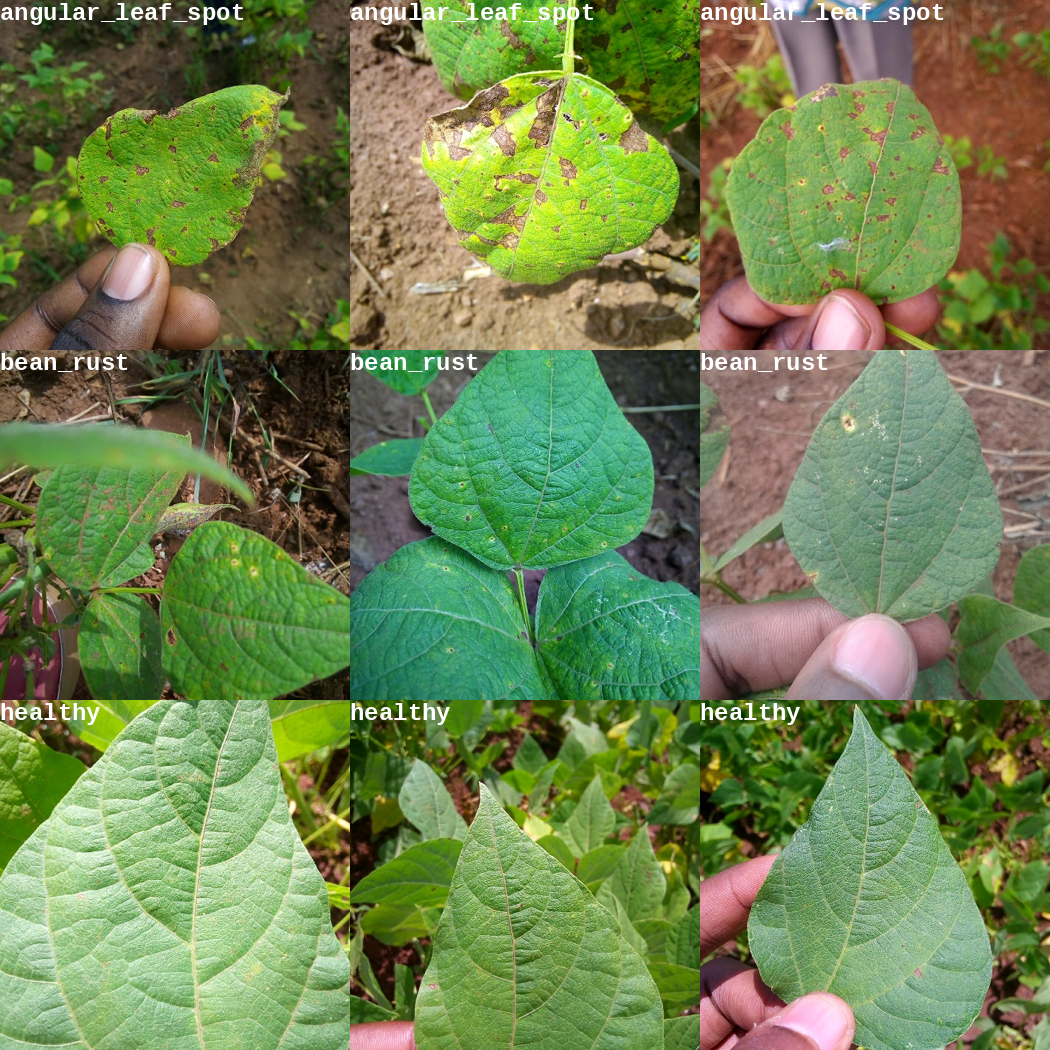

In [7]:
# 패키지 불러오기
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):
    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # 종류별로 데이터를 가져오고, 섞어서 몇 가지 샘플을 보여주도록 합니다
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # 각 행을 따라 시각화합니다
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

</p></br></br>


이렇게 파이썬 문서상에서 콩잎의 상태를 살펴볼 수 있는데요, 각 클래스별로 시각적인 특징이 나타나 있습니다.
</p></br></br>


- Angular Leaf Spot: 잎에 불규칙한 갈색 반점이 나타나 있는 상태
- Bean Rust: 끄트머리가 밝고, 둥근 갈색 반점이 곳곳에 나타나 있습니다
- Healthy: ...건강한 상태네요 🤷‍♂️
</p></br></br>



</p></br></br>


## ViT Feature Extractor 불러오기
---
이제는 파이썬에서 ViT 이미지 모델을 불러오고, 데이터를 학습시킬 일만 남았습니다. 이 과정은 모델에서 요구하는 방식으로 이미지를 변환하는 과정과 입력시키는 과정으로 나뉘어집니다.
</p></br></br>


이를 위해서, 우리는 [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) 와 함께 [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) 모델을 사용합니다. 허깅페이스 허브 🤗 에서 모델을 로드해 보겠습니다.
</p></br></br>



In [8]:
# ViT Feature Extractor 불러오기
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


</p></br></br>


이미지 처리를 위해, 사전 정의한 `feature_extractor` 에 이미지를 입력하는 과정을 거칩니다. 이 때, `return_tensors='pt'` 라고 매개변수를 추가할 경우, Numpy array 대신 torch tensor로 데이터를 전달받게 됩니다. 우리가 사용할 모델은 파이토치 기반이기 때문에 pt로 매개변수를 주도록 합시다.  
</p></br></br>



In [9]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [10]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

</p></br></br>


위에 보여드린 단일 처리 코드를 적용할 수 있지만, 조금 더 효율적인 처리를 위해 `transform` 함수를 따로 정의해 보도록 하겠습니다. 이 함수는 `inputs` 변수에 이미지의 tensor 값과 labels 정보를 함께 묶어서 전달하는 기능을 합니다.
</p></br></br>



In [11]:
ds = load_dataset('beans')

def transform(example_batch):
    # PIL 이미지를 픽셀 정보가 담긴 tensor로 변경합니다
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # 이미지 라벨을 입력합니다
    inputs['labels'] = example_batch['labels']
    return inputs

# 데이터에 일괄 적용
prepared_ds = ds.with_transform(transform)

In [12]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1843, -0.2471],
          [-0.6078, -0.6000, -0.5765,  ..., -0.0353, -0.0196, -0.2627],
          [-0.6314, -0.6314, -0.6078,  ..., -0.2314, -0.3647, -0.2235],
          ...,
          [-0.5373, -0.5529, -0.5843,  ..., -0.0824, -0.0431, -0.0902],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3098,  0.1843,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2627,  0.1608,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3647, -0.3255, -0.5686],
          [-0.7490, -0.7490, -0.7725,  ..., -0.5373, -0.6549, -0.5373],
          ...,
          [-0.7725, -0.7804, -0.8196,  ..., -0.2235, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1922,  0.3098,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0824,  0.2784,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3569, -0.7255],
          [-0

## 학습 및 평가
---
데이터 준비가 끝났으니 이제는 기계학습을 위한 파이프라인 설정을 할 차례입니다. 여기서는 Huggingface 🤗 에서 제공하는 Trainer를 이용해서 해당 작업을 진행할 예정입니다. 이를 위해서는 아래 절차를 따라야 합니다.
</p></br></br>


- 대조 기능을 정의합니다.

- 평가 지표를 정의하고, 훈련 도중에 모델의 정확도를 평가할 수 있는 `compute_metrics` 함수를 정의합니다.

- 학습 단계마다 체크포인트를 만들고 로드할 수 있도록 설정해야 합니다. (early stopping 기능 구현을 할 수 있겠죠!)

- 학습의 구성을 정의합니다.

이렇게 구성된 파이프라인을 이용해서, 모델의 미세 조정이 끝난 뒤에는 평가용 데이터(test set)을 이용해서 모델 평가를 진행하게 됩니다.  
</p></br></br>



</p></br></br>


### 대조 기능 정의하기
---
이번에는 `collate_fn` 이라는 함수를 정의합니다. 이 함수는 데이터를 모델에 입력하기 유용하게 만들기 위해, pixel_values와 labels를 key로 가지고 있고, 배치의 픽셀 정보와 라벨을 value로 가진 딕셔너리를 반환합니다.  
</p></br></br>



In [13]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

</p></br></br>


### 평가 지표 정의
---
그리고 기계학습 모델 평가를 위한 `compute_metric` 함수를 정의합니다. 이는 `datasets` 패키지의 `load_metric` 함수에서 제공하는 기능을 활용할 예정입니다. 평가 기준은 [accuracy](https://huggingface.co/metrics/accuracy) 로 설정합니다.  
</p></br></br>



In [14]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-14-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


</p></br></br>


이제, 학습 대상이 되는 모델을 로드해 보도록 하겠습니다. 이 때, 우리가 분류할 대상의 라벨 개수를 `num_labels` 로 따로 정의하는 과정이 필요합니다. 기존 딥러닝 모델은 우리가 몇 종류로 분류하기를 원하는지 알아차릴 수 없기 때문이지요.  
</p></br></br>


만약 push_to_hub 🤗 옵션을 선택할 예정인 경우, 사람이 라벨을 읽을 수 있도록 id2label 및 label2id 매핑 기능을 따로 정의해 주도록 합시다.  
</p></br></br>



In [15]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


</p></br></br>


이제 학습을 위한 준비가 거의 끝났습니다. 마지막으로 [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments) 라고 하는 클래스를 이용해 줘야 합니다. 여기서는 학습 과정에서 이용되는 다양한 옵션을 설정할 수 있는데, 대표적으로 `remove_unused_columns` 옵션이 있습니다. 이는 사용되지 않는 모든 feature를 지우는 설정이며, 이미지 등에서는 각 feature가 가지는 의미가 종합적으로 이용되어야 하기 때문에 이를 False로 설정해 두도록 합니다.  
</p></br></br>


참고로, 이 때 `accelerate` 패키지의 버전 문제가 생기는 경우가 있으므로, 아래 코드를 입력해 `transformers` 와 `acclerate` 패키지의 버전 의존성을 해결해 주시는 것을 추천드립니다.  
</p></br></br>



In [16]:
!pip install transformers[torch]
!pip install accelerate -U

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

</p></br></br>


이제, `Trainer` 클래스를 이용하여 딥러닝 모델을 학습하고, 이 학습 결과를 확인해 보도록 하겠습니다. 학습은 `train` 함수를 이용하며, 평가는 `evaluate` 함수를 이용합니다.  
</p></br></br>



In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

In [19]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.096200,0.060048,0.984962
200,0.044400,0.048545,0.984962


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1518
  train_runtime            =  0:02:34.21
  train_samples_per_second =      26.819
  train_steps_per_second   =       1.686


In [20]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0485
  eval_runtime            = 0:00:04.48
  eval_samples_per_second =     29.645
  eval_steps_per_second   =      3.789


</p></br></br>


학습 결과, 콩잎의 상태를 98.5% 정확도로 구분하는 것을 확인할 수 있습니다. 다른 파이썬 기계학습 모델에 비해서 꽤 좋은 정확도로 예측할 수 있네요.  
</p></br></br>


그리고, 아래 코드를 입력해서 학습된 모델을 Huggingface model hub로 공유할 수 있습니다. 아래 코드의 경우, [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans) 쪽으로 공유되도록 하는 코드이니, 모델 공유에 관심이 있는 분들이라면 참고해 보시기 바랍니다.
</p></br></br>


참고로, 이 코드는 `training_args` 구성시 `push_to_hub=True` 로 옵션을 설정한 경우 푸시할 수 있습니다. 이 때, `git-lfs` 패키지를 설치한 뒤, Huggingface 계정에 로그인을 해야 한다고 하네요. 로그인은 `huggingface-cli` 를 이용한다고 합니다.  
</p></br></br>



In [21]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)